# Feature Engineering for Telecom ML Platform

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 🔹 Start Spark session
spark = SparkSession.builder \
    .appName("TelecomDataProcessing") \
    .getOrCreate()

# 🔹 Paths
PROCESSED_PATH = "../data/processed/parquet/"

sns.set(style="whitegrid")

# Load processed datasets

In [6]:
traffic = spark.read.parquet(PROCESSED_PATH + "traffic_volume.parquet")
users = spark.read.parquet(PROCESSED_PATH + "user_churn_dataset.parquet")
plans = spark.read.parquet(PROCESSED_PATH + "user_plan_history.parquet")
profiles = spark.read.parquet(PROCESSED_PATH + "user_profiles.parquet")
towers = spark.read.parquet(PROCESSED_PATH + "tower_locations.parquet")
graph_edges = spark.read.parquet(PROCESSED_PATH + "telecom_graph_edges.parquet")
logs = spark.read.parquet(PROCESSED_PATH + "network_behaviors.parquet")

In [13]:
import os
import shutil

def save_dataframe(df, path, format="parquet", single_file=True, overwrite=True):
    """
    Save Spark DataFrame to disk in an easy-to-process format.

    Args:
        df (DataFrame): Spark DataFrame to save.
        path (str): Destination path (e.g., 'data/processed/users').
        format (str): 'csv' or 'parquet'.
        single_file (bool): If True, output will be a single file (coalesce + move).
        overwrite (bool): If True, overwrite existing files.

    Returns:
        str: Final path to the saved file or directory.
    """
    import os
    import shutil

    if overwrite and os.path.exists(path):
        shutil.rmtree(path)

    temp_path = path + "_tmp"
    df_to_save = df.coalesce(1) if single_file else df
    writer = df_to_save.write.option("header", True).mode("overwrite")

    if format == "csv":
        writer.csv(temp_path)
    elif format == "parquet":
        writer.parquet(temp_path)
    else:
        raise ValueError("Unsupported format. Use 'csv' or 'parquet'.")

    if single_file:
        part_file = None
        for fname in os.listdir(temp_path):
            if fname.startswith("part-") and fname.endswith(f".{format}"):
                part_file = fname
                break
        if part_file:
            final_path = path + f".{format}"
            shutil.move(os.path.join(temp_path, part_file), final_path)
            shutil.rmtree(temp_path)
            return final_path
    else:
        if os.path.exists(path):
            shutil.rmtree(path)
        shutil.move(temp_path, path)
        return path

# ─────────────────────────────────────────────
# 🧠 Feature Engineering
# ─────────────────────────────────────────────

### Time-based features from traffic data

In [8]:
traffic = traffic.withColumn("hour", F.to_timestamp("hour"))
traffic = traffic.withColumn("hour_of_day", F.hour("hour"))
traffic = traffic.withColumn("day_of_week", F.dayofweek("hour"))

### Aggregate user features

In [9]:
user_features = plans.groupBy("user_id").agg(
    F.mean("minutes_used").alias("avg_minutes"),
    F.mean("data_used_gb").alias("avg_data"),
    F.mean("satisfaction_score").alias("avg_satisfaction")
)

### Merge with user churn dataset

In [10]:
users

DataFrame[user_id: string, churned: int, avg_minutes: double, avg_data_gb: double, avg_satisfaction: double]

In [14]:
user_merged = users.join(profiles, on="user_id", how="left")

existing_cols = set(user_merged.columns)
new_cols = [col for col in user_features.columns if col not in existing_cols or col == "user_id"]

user_features_filtered = user_features.select(new_cols)

user_merged = user_merged.join(user_features_filtered, on="user_id", how="left")

save_path = save_dataframe(user_merged, PROCESSED_PATH + "user_feature_matrix", format="parquet")
print(f"✅ Saved: user_feature_matrix → {save_path}")

✅ Saved: user_feature_matrix → ../data/processed/parquet/user_feature_matrix.parquet


### Tower-level features

In [15]:
tower_agg = traffic.groupBy("tower_id").agg(
    F.mean("total_calls").alias("avg_calls"),
    F.mean("total_data_used_mb").alias("avg_data_mb")
    )

# Merge with tower geo info
tower_features = tower_agg.join(towers, on="tower_id", how="left")

save_path = save_dataframe(tower_features, PROCESSED_PATH + "tower_feature_matrix", format="parquet")
print(f"✅ Saved: tower_feature_matrix → {save_path}")

✅ Saved: tower_feature_matrix → ../data/processed/parquet/tower_feature_matrix.parquet


# ─────────────────────────────────────────────
# 📊 Quick EDA Plots
# ─────────────────────────────────────────────

### Average User Data Usage Distribution

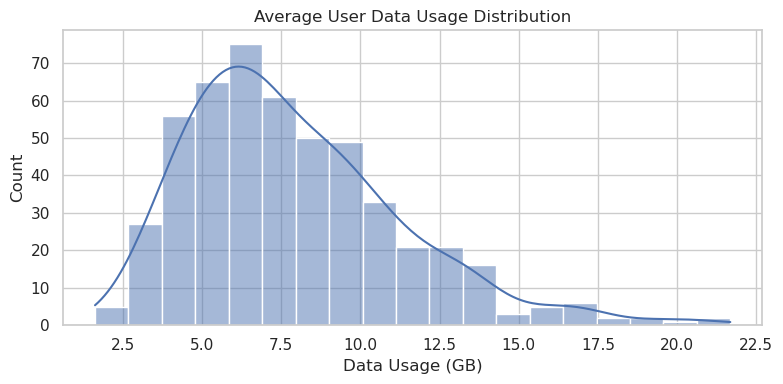

In [17]:
user_data_pd = user_merged.select("avg_data").dropna().toPandas()

plt.figure(figsize=(8, 4))
sns.histplot(user_data_pd["avg_data"], kde=True)
plt.title("Average User Data Usage Distribution")
plt.xlabel("Data Usage (GB)")
plt.tight_layout()
plt.show()

### Churn vs. Average Call Minutes

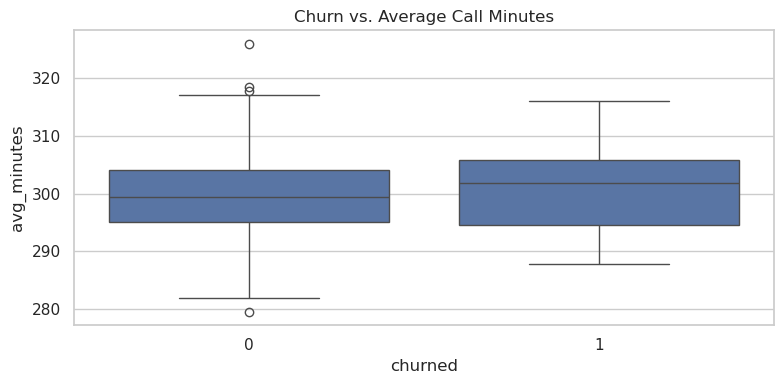

In [18]:
user_data_pd = user_merged.select(["churned", "avg_minutes"]).dropna().toPandas()

plt.figure(figsize=(8, 4))
sns.boxplot(x="churned", y="avg_minutes", data=user_data_pd)
plt.title("Churn vs. Average Call Minutes")
plt.tight_layout()
plt.show()

### User Churn Analysis

Text(0.5, 1.0, 'Churn Distribution')

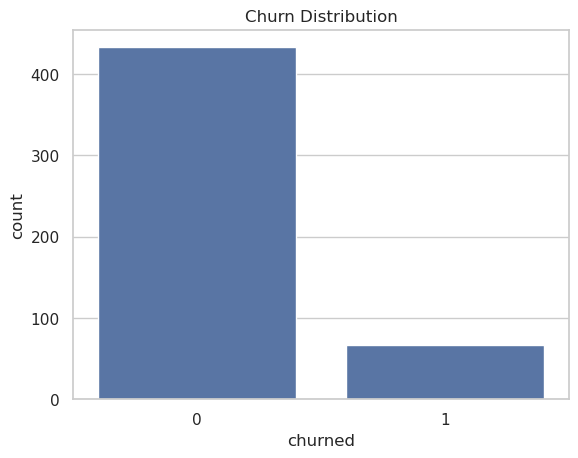

In [20]:
user_feature_matrix = spark.read.parquet(PROCESSED_PATH + "user_feature_matrix.parquet")
user_data_pd = user_merged.select("churned").dropna().toPandas()
sns.countplot(x='churned', data=user_data_pd)
plt.title('Churn Distribution')